In [1]:
from torch import nn
import torch
import os
import json
import pickle
import numpy as np
import pywt
#from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
train_dir = "../../"
my_train_data = {"x": [], "y": []}

In [2]:
torch.manual_seed(13)

In [3]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [4]:
device

'cpu'

In [5]:
torch.set_num_threads(6)

## Contents
* [CNN Model Training](#train)
* [Optimizer analysis](#optim)
* [FFT](#fft)
* [Wavelets](#wt)
* [FFT Training](#ffttrain)
* [Node_Training](#nodetraining)

## CNN Model Training <a class="anchor" id="train"></a>

In [6]:
# From Femnist.py
def read_file(file_path):
    with open(file_path, "r") as inf:
        client_data = json.load(inf)
        print("loaded the data")
    return (
        client_data["users"],
        client_data["num_samples"],
        client_data["user_data"],
    )

In [7]:
with open(train_dir+"femnist.pkl", "rb") as f:
    train = pickle.load(f)

In [8]:
with open(train_dir+"femnist_test.pkl", "rb") as f:
    test = pickle.load(f)

In [9]:
train["train_x"].shape

(735856, 1, 28, 28)

In [10]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 32
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [11]:
NUM_CLASSES = 62
IMAGE_SIZE = (28, 28)
FLAT_SIZE = 28 * 28
PIXEL_RANGE = 256.0

model = ResNet(BasicBlock, [2,2,2,2], num_classes=62,  width_per_group=32)



In [12]:
flat = []
for v in model.state_dict().values():
    flat.append(v.flatten())
conc = torch.cat(flat)

In [13]:
conc.shape

torch.Size([2816498])

In [14]:
import os
from torch.utils.data import Dataset

class FemnistDataset(Dataset):
    def __init__(self, training, transform=None, target_transform=None):
        if training:
            with open(train_dir+"femnist.pkl", "rb") as f:
                train = pickle.load(f)
                self.data = train["train_x"]
                self.label = train["train_y"]
        else: 
            with open(train_dir+"femnist_test.pkl", "rb") as f:
                test = pickle.load(f)
                self.data = test["test_x"]
                self.label = test["test_y"]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [15]:
from torch.utils.data import DataLoader

In [16]:
trainset = FemnistDataset(True)
testset = FemnistDataset(False)

train_dataloader = DataLoader(trainset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=True)

In [17]:
lr = 0.0005
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
list(model.state_dict().values())[1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
for v in model.state_dict().values():
    flat.append(v.flatten())
conc = torch.cat(flat)

In [27]:
o = 10800
print(conc[o:o+1000])

tensor([-3.6153e-02,  1.0922e-02,  1.5911e-01,  7.6926e-02,  5.7525e-02,
         2.0833e-01,  4.8255e-02,  2.0805e-01, -2.4887e-02,  8.3241e-02,
         5.7281e-02,  3.2598e-02, -5.9614e-03,  2.3448e-01, -2.7755e-02,
         1.2072e-01,  2.0834e-03,  1.4729e-01, -2.0169e-01, -2.3126e-03,
        -1.0632e-02,  1.1928e-02, -1.2216e-01, -1.3769e-03, -1.1989e-01,
        -2.1655e-02,  1.6833e-02, -1.0780e-01,  5.3008e-02,  1.1340e-01,
        -1.1262e-01, -2.9909e-02, -1.3595e-01,  1.1996e-01, -3.5497e-02,
        -5.9646e-02, -8.5283e-03, -3.5111e-02, -7.9876e-03,  4.3423e-02,
         8.0446e-02,  1.3475e-01, -1.7352e-02,  1.5214e-01,  5.7564e-02,
        -1.2092e-02,  4.2873e-02, -4.6847e-02, -1.5831e-01,  3.2632e-02,
         1.2103e-02, -7.3686e-02,  5.8829e-02, -4.9315e-02,  1.1395e-02,
        -1.2393e-02,  3.4627e-02, -2.0724e-02, -7.6100e-02,  1.5033e-02,
        -6.2240e-02,  1.3045e-01,  2.9429e-02,  5.1437e-02,  5.2329e-02,
         2.4896e-02, -1.8821e-02, -4.8809e-02, -6.7

In [ ]:
stats = {"train": [], "test":[]}
for e in range(10):
    #training
    batch = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        size = len(train_dataloader.dataset)
        model.train()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.317379  [    0/735856]
loss: 1.467329  [12800/735856]
loss: 0.863656  [25600/735856]
loss: 0.814204  [38400/735856]
loss: 0.746839  [51200/735856]
loss: 0.734121  [64000/735856]
loss: 0.761491  [76800/735856]
loss: 0.680998  [89600/735856]
loss: 0.731149  [102400/735856]
loss: 0.826501  [115200/735856]
loss: 0.662327  [128000/735856]
loss: 0.612664  [140800/735856]
loss: 0.755015  [153600/735856]
loss: 0.400373  [166400/735856]
loss: 0.558040  [179200/735856]
loss: 0.603362  [192000/735856]
loss: 0.418064  [204800/735856]
loss: 0.628256  [217600/735856]
loss: 0.377127  [230400/735856]
loss: 0.420045  [243200/735856]
loss: 0.558597  [256000/735856]
loss: 0.438556  [268800/735856]
loss: 0.684690  [281600/735856]
loss: 0.590059  [294400/735856]
loss: 0.557874  [307200/735856]
loss: 0.494909  [320000/735856]
loss: 0.617219  [332800/735856]
loss: 0.351243  [345600/735856]
loss: 0.454522  [358400/735856]
loss: 0.429664  [371200/735856]
loss: 0.468215  [384000/735856]
loss: 0.401258  

In [ ]:
with open(train_dir+"/results:128:"+str(lr)+".pkl", "wb") as f:
  pickle.dump(stats, f)

In [ ]:
lrs = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
for l in lrs:
  with open(train_dir+"/results:128:"+str(l)+".pkl", "rb") as f:
    res = pickle.load(f)
    print(str(l)+": " + str(np.amax(res["test"], axis=0)))#+ str(np.max(res["test"]))
    # print(str(l)+": " + str(res["test"]))
    

In [61]:
lrs = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
for l in lrs:
  with open(train_dir+"/results:128:"+str(l)+".pkl", "rb") as f:
    res = pickle.load(f)
    # print(str(l)+": " + str(np.amax(res["test"], axis=0)))#+ str(np.max(res["test"]))
    print(str(l)+": " + str(res["test"]))

0.1: [[0, 3.6898819485246297, 4.914933837429111], [1, 3.695287103771977, 4.914933837429111], [2, 3.691172517592003, 5.505213732544667], [3, 3.6920483804158226, 4.967376059515824], [4, 3.6939517986755845, 5.505213732544667], [5, 3.6917366434742993, 4.914933837429111], [6, 3.695435837910811, 5.505213732544667], [7, 3.6978058357506574, 5.135679004817367], [8, 3.6948341036363623, 5.505213732544667], [9, 3.6921330658768343, 5.135679004817367]]
0.01: [[0, 0.5728003431500958, 81.8086468687115], [1, 0.5517885946725348, 82.61967193121532], [2, 3.984756194857093, 25.844258796268065], [3, 0.5739870879932797, 81.7476675407037], [4, 0.7832032613188912, 75.77779132873955], [5, 0.7142617320772638, 77.80474419171901], [6, 0.6602287095348103, 79.28654186230868], [7, 0.6738644539380036, 79.2719068235868], [8, 0.6469118589079138, 79.77071772669065], [9, 0.6788249858734946, 79.28898103542899]]
0.005: [[0, 0.4834194714537649, 83.79047502896519], [1, 0.466142692822562, 84.33928898103544], [2, 0.455976727879

In [ ]:
import torch
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /home/jeffrey/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
total = 0
for i in resnet.state_dict().values():
    total += i.flatten().size(dim=0)
print(total)

11699132


## Optimizer analysis <a class="anchor" id="optim"></a>

In [13]:
# internal state test
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
old = model.state_dict()

In [12]:
old["conv1.bias"]

tensor([-0.0877, -0.1623, -0.0757, -0.1486,  0.1212,  0.1070,  0.0221, -0.1306,
         0.0798, -0.1525, -0.0297, -0.1715,  0.1039,  0.0143,  0.0982,  0.0428,
        -0.0983, -0.0698,  0.1894,  0.1400,  0.0139, -0.0640,  0.0410, -0.0332,
        -0.0993, -0.0840, -0.1224,  0.0723,  0.1994,  0.0017, -0.1309,  0.0044])

In [13]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()

In [14]:
model.state_dict()["conv1.bias"]

tensor([-0.1695,  0.0365,  0.0043, -0.0058,  0.1130,  0.1614, -0.1921,  0.0229,
         0.1472,  0.0111, -0.1327, -0.0368,  0.0536, -0.0637,  0.1539,  0.1022,
         0.1948, -0.1443,  0.1046,  0.1746,  0.1998, -0.0572,  0.0675, -0.1533,
        -0.1863, -0.0397,  0.1823, -0.0121,  0.0045,  0.0704,  0.1362,  0.1068])

In [15]:
old["conv1.bias"]

tensor([-0.0877, -0.1623, -0.0757, -0.1486,  0.1212,  0.1070,  0.0221, -0.1306,
         0.0798, -0.1525, -0.0297, -0.1715,  0.1039,  0.0143,  0.0982,  0.0428,
        -0.0983, -0.0698,  0.1894,  0.1400,  0.0139, -0.0640,  0.0410, -0.0332,
        -0.0993, -0.0840, -0.1224,  0.0723,  0.1994,  0.0017, -0.1309,  0.0044])

In [16]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0005,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

In [17]:
for p in model.parameters():
    print(type(p))

<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>


In [18]:
len(optimizer.param_groups[0]["params"])

8

In [19]:
optimizer.param_groups[1]

IndexError: list index out of range

In [20]:
optimizer.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad'])

In [21]:
optimizer.param_groups[0]["params"][1]

Parameter containing:
tensor([-0.0877, -0.1623, -0.0757, -0.1486,  0.1212,  0.1070,  0.0221, -0.1306,
         0.0798, -0.1525, -0.0297, -0.1715,  0.1039,  0.0143,  0.0982,  0.0428,
        -0.0983, -0.0698,  0.1894,  0.1400,  0.0139, -0.0640,  0.0410, -0.0332,
        -0.0993, -0.0840, -0.1224,  0.0723,  0.1994,  0.0017, -0.1309,  0.0044],
       requires_grad=True)

In [ ]:
# --> yes the optimizer values do not get updates

In [22]:
optimizer.state

defaultdict(dict, {})

In [ ]:
# optimizer.state is a dictionary that gets filled during the first step() call
# as keys it has the params and as values it has the internal state of the optimizer (first momentum, second momentum etc)
# stored the values in vals, they are from running the training loop

In [12]:
len(vals)

8

In [20]:
vals_list = list(vals)

In [21]:
len(vals_list)

8

In [22]:
vals_list[1] # entry for 

{'step': 69,
 'exp_avg': tensor([-1.4137e-03, -1.0432e-02, -5.7605e-03, -1.5292e-02, -1.1802e-02,
          1.1299e-03,  2.1533e-03, -9.7591e-03, -8.8733e-03, -4.7788e-03,
         -1.9228e-03, -5.7594e-03, -5.4949e-05, -3.8590e-05,  1.3072e-04,
         -7.8018e-03, -6.1446e-04, -2.9151e-03, -3.3301e-03, -2.0083e-03,
         -3.0533e-03, -3.5316e-04, -8.1218e-03,  5.7864e-04,  5.8342e-04,
         -1.1397e-02, -8.2111e-04, -6.8639e-03, -7.7449e-04,  1.0854e-04,
         -4.7743e-05, -9.0613e-03]),
 'exp_avg_sq': tensor([9.6760e-06, 2.4495e-05, 8.1120e-06, 3.0419e-05, 1.0932e-05, 2.3003e-05,
         1.9296e-05, 1.5492e-05, 2.6551e-06, 1.1472e-05, 2.6787e-05, 9.0655e-05,
         8.7915e-11, 3.1380e-05, 4.9582e-06, 3.9729e-06, 7.5247e-06, 1.8417e-05,
         6.9078e-06, 2.9552e-05, 5.0895e-06, 1.6462e-06, 2.1158e-06, 2.8078e-06,
         2.5839e-06, 2.6732e-05, 2.0372e-05, 9.5084e-07, 2.0701e-06, 1.2862e-06,
         1.5106e-06, 2.5722e-05])}

In [ ]:
# The most feasible solution would be to create a new optimizer and then 
# vals = list(optimizer.state.values())
# create new optimizer
# for i, k in enmumerate(optimizer.param_groups[0]["params"]):
#     optimizer.state[k] = vals[i]
# https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
# https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer

## FFT <a class="anchor" id="fft"></a>

In [14]:
train["train_x"].shape

(735856, 1, 28, 28)

In [15]:
735856 / 128

5748.875

In [15]:
weights = {}

In [16]:
stats = {"train": [], "test":[]}
batch = 0
for e in range(3):
    #training
    for X, y in train_dataloader:
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
            weight = {}
            for k,v in model.state_dict().items():
                weight[k] = v.clone()
            
            weights[str(batch)] = weight
        batch += 1

loss: 4.124378  [    0/735856]
loss: 1.539611  [64000/735856]
loss: 0.719579  [128000/735856]
loss: 0.685157  [192000/735856]
loss: 0.778637  [256000/735856]
loss: 0.493262  [320000/735856]
loss: 0.423785  [384000/735856]
loss: 0.531239  [448000/735856]
loss: 0.803173  [512000/735856]
loss: 0.498672  [576000/735856]
loss: 0.453685  [640000/735856]
loss: 0.355350  [704000/735856]
loss: 0.417364  [768000/735856]
loss: 0.462418  [832000/735856]
loss: 0.361217  [896000/735856]
loss: 0.484760  [960000/735856]
loss: 0.360997  [1024000/735856]
loss: 0.353997  [1088000/735856]
loss: 0.378490  [1152000/735856]
loss: 0.376164  [1216000/735856]
loss: 0.375268  [1280000/735856]
loss: 0.570408  [1344000/735856]
loss: 0.295247  [1408000/735856]
loss: 0.257762  [1472000/735856]
loss: 0.609368  [1536000/735856]
loss: 0.423437  [1600000/735856]
loss: 0.363265  [1664000/735856]
loss: 0.393251  [1728000/735856]
loss: 0.353971  [1792000/735856]
loss: 0.279443  [1856000/735856]
loss: 0.532804  [1920000/735

In [17]:
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print("epoch:")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
stats["test"].append([e, test_loss, 100*correct])

epoch:
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.367197 



In [18]:
weights.keys()

dict_keys(['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000', '4500', '5000', '5500', '6000', '6500', '7000', '7500', '8000', '8500', '9000', '9500', '10000', '10500', '11000', '11500', '12000', '12500', '13000', '13500', '14000', '14500', '15000', '15500', '16000', '16500', '17000'])

* 1d on flattend
* 1d on layers
* nd on layers

In [25]:
# working on the random initialization
flat = []
for v in weights["17000"].values():
    flat.append(v.flatten())
conc = torch.cat(flat)

In [26]:
len(conc)

1690046

In [27]:
conc[0:10]

tensor([-0.1440, -0.0482,  0.2070, -0.2534, -0.2413,  0.0336, -0.2401,  0.2761,
         0.2361, -0.2687])

In [28]:
import torch.fft as fft

In [29]:
flat_fft = fft.fft(conc)
len(flat_fft)

1690046

In [30]:
flat_fft = fft.rfft(conc)
len(flat_fft)

845024

In [31]:
flat_fft

tensor([-3912.2754+0.0000j,  -685.3215+117.2780j,  -718.2836-68.4478j,
         ...,    33.0949-6.6868j,    49.2176+6.2663j,
           -9.9980+0.0000j])

In [32]:
reverse = fft.irfft(flat_fft)

In [33]:
reverse[0:10]

tensor([-0.1440, -0.0482,  0.2070, -0.2534, -0.2413,  0.0336, -0.2401,  0.2761,
         0.2361, -0.2687])

In [34]:
torch.norm(conc - reverse, 2)

tensor(0.0004)

In [35]:
top10 = torch.zeros(flat_fft.size(dim=0), dtype = torch.cfloat)
top10[0:84502] = flat_fft[0:84502]

In [36]:
top10

tensor([-3912.2754+0.0000j,  -685.3215+117.2780j,  -718.2836-68.4478j,
         ...,     0.0000+0.0000j,     0.0000+0.0000j,
            0.0000+0.0000j])

In [37]:
reverse_t10 = fft.irfft(top10)

In [38]:
reverse_t10[0:10]

tensor([-0.0439, -0.0400, -0.0357, -0.0312, -0.0269, -0.0229, -0.0193, -0.0162,
        -0.0134, -0.0109])

In [39]:
torch.norm(reverse_t10 - reverse, 2)

tensor(40.2866)

In [40]:
d10 = torch.zeros(flat_fft.size(dim=0), dtype = torch.cfloat)
d10[-84502:] = flat_fft[-84502:]

In [41]:
reverse_d10 = fft.irfft(d10)

In [42]:
reverse_d10[0:10]

tensor([-0.0026,  0.0042, -0.0056,  0.0065, -0.0065,  0.0053, -0.0029, -0.0008,
         0.0059, -0.0120])

In [43]:
torch.norm(reverse_d10 - reverse, 2)

tensor(43.7672)

In [44]:
torch.norm(reverse, 2)

tensor(44.8886)

In [45]:
rand = torch.rand(conc.size(dim=0))

In [46]:
torch.norm(rand - reverse, 2)

tensor(754.6744)

In [47]:
torch.norm(reverse_d10 - reverse, 1)

tensor(29442.5273)

In [48]:
torch.norm(reverse_t10 - reverse, 1)

tensor(27450.3555)

In [49]:
torch.norm(reverse, 1)

tensor(30432.2695)

In [50]:
torch.norm(reverse, 2)

tensor(44.8886)

In [51]:
flat_fft

tensor([-3912.2754+0.0000j,  -685.3215+117.2780j,  -718.2836-68.4478j,
         ...,    33.0949-6.6868j,    49.2176+6.2663j,
           -9.9980+0.0000j])

In [52]:
flat_fft.abs()

tensor([3912.2754,  695.2839,  721.5375,  ...,   33.7637,   49.6149,
           9.9980])

In [53]:
import matplotlib.pyplot as plt

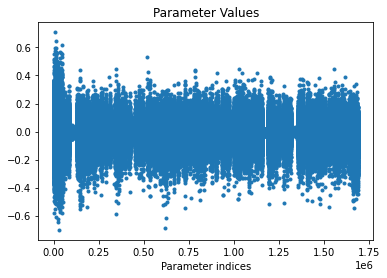

In [54]:
plt.plot(torch.arange(0,len(conc)), conc, '.')
plt.title('Parameter Values') 
plt.xlabel("Parameter indices")
plt.draw()
plt.savefig("Parameter_Values.png")

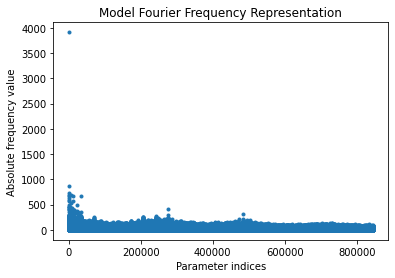

In [55]:
plt.plot(torch.arange(0,len(flat_fft)), flat_fft.abs(), '.')
plt.title('Model Fourier Frequency Representation') 
plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter indices")
plt.draw()
plt.savefig("Parameter_Frequency.png")

## Normalizing

In [56]:
torch.mean(conc)

tensor(-0.0023)

In [57]:
conc2 = conc #+ 0.0016

In [58]:
torch.mean(conc2)

tensor(-0.0023)

In [59]:
flat_fft2 = fft.rfft(conc)

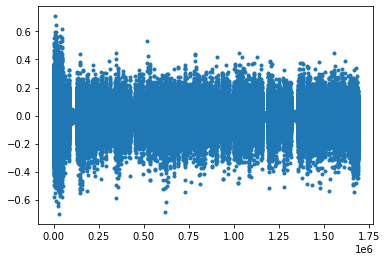

In [60]:
plt.plot(torch.arange(0,len(conc2)), conc2, '.')

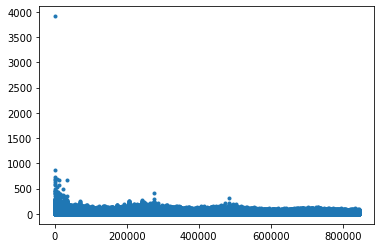

In [61]:
plt.plot(torch.arange(0,len(flat_fft2)), flat_fft2.abs(), '.')

In [62]:
topk = torch.topk(
            flat_fft2.abs(), round(0.1*len(flat_fft2)), dim=0, sorted=False
        )

In [63]:
topk

torch.return_types.topk(
values=tensor([ 75.7603, 695.2839, 721.5375,  ...,  68.1649,  68.1649,  68.1649]),
indices=tensor([294037,      1,      2,  ..., 241565, 434039, 328013]))

In [64]:
topk.indices

tensor([294037,      1,      2,  ..., 241565, 434039, 328013])

In [65]:
top10 = torch.zeros(len(flat_fft2), dtype = torch.cfloat)
top10[topk.indices] = flat_fft2[topk.indices]

In [66]:
len(topk.indices)

84502

In [67]:
reverse_top10 = fft.irfft(top10)

In [68]:
torch.norm(reverse_top10 - conc2, 2)

tensor(34.8182)

In [69]:
torch.norm(conc2, 2) 

tensor(44.8886)

In [70]:
torch.norm(reverse_top10 - conc2, 1)

tensor(30254.6758)

In [71]:
topk_og = torch.topk(
            conc2.abs(), round(0.1*len(conc2)), dim=0, sorted=False
        )

In [72]:
len(topk_og.indices)

169005

In [73]:
topk_og.indices[topk_og.indices<50]

tensor([ 1,  2,  3,  4,  0,  6,  7,  8,  9, 10, 11, 12, 13, 16, 18, 19, 20, 21,
        22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42,
        44, 45, 46, 47, 48, 49, 39])

In [74]:
top10_og = torch.zeros(len(conc2))
top10_og[topk_og.indices] = conc2[topk_og.indices]

In [75]:
torch.norm(top10_og - conc2, 2) 

tensor(15.5541)

In [76]:
torch.norm(top10_og - conc2, 1)

tensor(15858.2695)

In [77]:
reverse_top10[10000:10050]

tensor([-0.0058, -0.0441, -0.0381, -0.0493, -0.0240,  0.0190, -0.0132, -0.0221,
        -0.0472,  0.0077,  0.0236,  0.0183,  0.0231,  0.0014, -0.0245, -0.0085,
         0.0035, -0.0036,  0.0150,  0.0107,  0.0123,  0.0039,  0.0003, -0.0320,
        -0.0093,  0.0632,  0.0360,  0.0200, -0.0248,  0.0029, -0.0011, -0.0193,
         0.0221,  0.0056, -0.0091, -0.0008,  0.0329,  0.0133, -0.0078, -0.0061,
        -0.0372, -0.0354, -0.0238, -0.0028,  0.0145, -0.0121, -0.0517, -0.0468,
        -0.0123, -0.0132])

In [78]:
conc2 [10000:10050]

tensor([ 0.0155,  0.0128, -0.0386,  0.0186,  0.0166,  0.0259, -0.0200, -0.0033,
        -0.0399,  0.0214,  0.0106,  0.0197, -0.0182, -0.0191, -0.0370,  0.0159,
         0.0071, -0.0321, -0.0166, -0.0082,  0.0090,  0.0291,  0.0117,  0.0011,
         0.0066,  0.0163,  0.0237,  0.0092, -0.0029, -0.0209, -0.0207,  0.0039,
         0.0065,  0.0057,  0.0316, -0.0262, -0.0342, -0.0115,  0.0149, -0.0175,
        -0.0568, -0.0135, -0.0503, -0.0252,  0.0148, -0.0429, -0.0424, -0.0182,
        -0.0002, -0.0341])

In [79]:
top10_og[10000:10050]

tensor([ 0.0000,  0.0000, -0.0386,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0399,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0370,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0568,  0.0000, -0.0503,  0.0000,  0.0000, -0.0429, -0.0424,  0.0000,
         0.0000,  0.0000])

In [80]:
conc2[0:10000]

tensor([-0.1440, -0.0482,  0.2070,  ...,  0.0011,  0.0177, -0.0218])

In [81]:
reverse_top10fft = reverse_top10

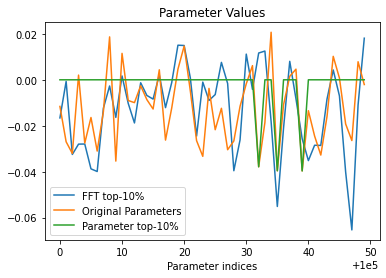

In [82]:
plt.plot(np.arange(100000,100050,1), reverse_top10fft[100000:100050], label = "FFT top-10%")
plt.plot(np.arange(100000,100050,1), conc2[100000:100050], label = "Original Parameters")
plt.plot(np.arange(100000,100050,1), top10_og[100000:100050], label = "Parameter top-10%")
plt.title('Parameter Values') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter indices")
plt.legend()
plt.draw()
plt.savefig("Parameters.png")

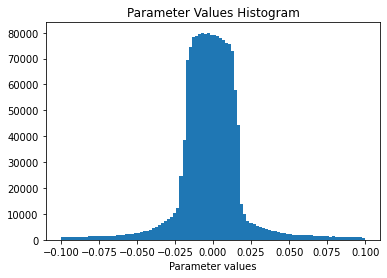

In [83]:
plt.hist(conc2.numpy(), 100, (-0.1,0.1))
plt.title('Parameter Values Histogram') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter values")
plt.draw()
plt.savefig("Parameter_Histogram.png")

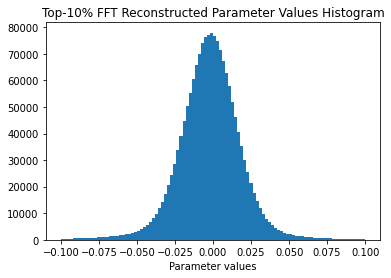

In [84]:
plt.hist(reverse_top10.numpy(), 100, (-0.1,0.1))
plt.title('Top-10% FFT Reconstructed Parameter Values Histogram') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter values")
plt.draw()
plt.savefig("FFT_Histogram.png")

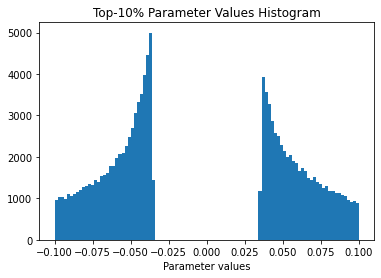

In [85]:
plt.hist(top10_og[top10_og.abs() >0].numpy(), 100, (-0.1,0.1))
plt.title('Top-10% Parameter Values Histogram') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter values")
plt.draw()
plt.savefig("top10_Histogram.png")

In [86]:
top10_og[top10_og.abs() >0].numpy()

array([-0.14400896, -0.04817872,  0.20703338, ...,  0.0729612 ,
       -0.06001848, -0.03798665], dtype=float32)

### Per Layer

In [87]:
flat5000 = []
for v in weights["17000"].values():
    flat5000.append(v.flatten())
conc500 = torch.cat(flat5000)

In [88]:
torch.norm(conc500, 2)

tensor(44.8886)

In [134]:
# working on the random initialization
errs = []
lens = []
fft_layers = []
for v in weights["17000"].values():
    flat = v.flatten()
    lens.append(len(flat))
    flat_fft = fft.rfft(flat)
    topk = torch.topk(
            flat_fft.abs(), round(0.1*len(flat_fft)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_fft), dtype = torch.cfloat)
    top10[topk.indices] = flat_fft[topk.indices]
    reverse_top10 = fft.irfft(top10)
    fft_layers.append(reverse_top10)
    err = torch.norm(reverse_top10 - flat, 2)
    print(err)
    errs.append(err*err)


tensor(3.8334)
tensor(0.5911)
tensor(14.2745)
tensor(0.2714)
tensor(29.4115)
tensor(0.4823)
tensor(9.3226)
tensor(0.3447)


In [135]:
lens

[800, 32, 51200, 64, 1605632, 512, 31744, 62]

In [136]:
np.sum(errs)

1171.1743

In [137]:
np.sqrt(np.sum(errs))

34.222424

In [93]:
fft_conc = torch.cat(fft_layers)

In [94]:
torch.norm(fft_conc - conc5000
           ,2)

NameError: name 'conc5000' is not defined

Almost no difference in layerwise vs over the entire weight

In [138]:
weights.keys()

dict_keys(['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000', '4500', '5000', '5500', '6000', '6500', '7000', '7500', '8000', '8500', '9000', '9500', '10000', '10500', '11000', '11500', '12000', '12500', '13000', '13500', '14000', '14500', '15000', '15500', '16000', '16500', '17000'])

In [139]:
# working on the random initialization
errs = []
lens = []
for v in weights["17000"].values():
    flat = v.flatten()
    lens.append(len(flat))
    topk = torch.topk(
            flat.abs(), round(0.1*len(flat)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat))
    top10[topk.indices] = flat[topk.indices]
    err = torch.norm(top10 - flat, 2)
    print(err)
    errs.append(err*err)

tensor(3.8017)
tensor(0.6525)
tensor(9.6627)
tensor(0.2314)
tensor(14.0121)
tensor(0.3602)
tensor(6.0212)
tensor(0.3187)


In [140]:
lens

[800, 32, 51200, 64, 1605632, 512, 31744, 62]

In [141]:
np.sum(errs)

341.1233

In [142]:
np.sqrt(np.sum(errs))

18.469522

In [99]:
flat5000 = []
for v in weights["17000"].values():
    flat5000.append(v.flatten())
conc5000 = torch.cat(flat5000)

In [100]:
torch.norm(conc5000, 2)

tensor(44.8886)

In [101]:
# working on the random initialization
errs = []
errs1 = []
lens = []
fft_layers = []
for v in weights["1000"].values():
    flat = v.flatten()
    lens.append(len(flat))
    flat_fft = fft.rfft(flat)
    topk = torch.topk(
            flat_fft.abs(), round(0.2*len(flat_fft)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_fft), dtype = torch.cfloat)
    top10[topk.indices] = flat_fft[topk.indices]
    reverse_top10 = fft.irfft(top10)
    fft_layers.append(reverse_top10)
    err = torch.norm(reverse_top10 - flat, 2)
    errs1.append(torch.norm(reverse_top10 - flat, 1))
    print(err)
    errs.append(err*err)

tensor(2.5049)
tensor(0.4643)
tensor(6.6074)
tensor(0.1233)
tensor(12.2971)
tensor(0.1902)
tensor(4.0843)
tensor(0.1482)


In [102]:
lens

[800, 32, 51200, 64, 1605632, 512, 31744, 62]

In [103]:
np.sum(errs)

218.12065

In [104]:
np.sqrt(np.sum(errs))

14.7689085

In [105]:
fft_conc = torch.cat(fft_layers)

In [106]:
torch.norm(fft_conc - conc5000,2)

tensor(39.6843)

In [107]:
errs1

[tensor(57.1960),
 tensor(2.2182),
 tensor(1148.8655),
 tensor(0.7960),
 tensor(12109.6943),
 tensor(3.3738),
 tensor(578.7853),
 tensor(0.9163)]

In [108]:
np.sum(errs1)

13901.846

In [109]:
# working on the random initialization
errs = []
lens = []
errs1 = []
for v in weights["17000"].values():
    flat = v.flatten()
    lens.append(len(flat))
    topk = torch.topk(
            flat.abs(), round(0.1*len(flat)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat))
    top10[topk.indices] = flat[topk.indices]
    err = torch.norm(top10 - flat, 2)
    print(err)
    errs.append(err*err)
    errs1.append(torch.norm(top10 - flat, 1))

tensor(3.8017)
tensor(0.6525)
tensor(9.6627)
tensor(0.2314)
tensor(14.0121)
tensor(0.3602)
tensor(6.0212)
tensor(0.3187)


In [110]:
lens

[800, 32, 51200, 64, 1605632, 512, 31744, 62]

In [111]:
np.sum(errs)

341.1233

In [112]:
np.sqrt(np.sum(errs))

18.469522

In [113]:
errs1

[tensor(86.4496),
 tensor(3.1551),
 tensor(1531.9570),
 tensor(1.5015),
 tensor(14199.5361),
 tensor(6.1879),
 tensor(814.4448),
 tensor(2.0511)]

In [114]:
np.sum(errs1)

16645.283

In [115]:
flat5000 = []
for v in weights["17000"].values():
    print(v.grad)
    flat5000.append(v.flatten())
conc5000 = torch.cat(flat5000)

None
None
None
None
None
None
None
None


## Wavelets  <a class="anchor" id="wt"></a>

In [116]:
!pip install PyWavelets

In [117]:
import pywt

In [118]:
#(cA, cD) = pywt.dwt(, 'db1')

In [24]:
# pywt.wavelist(kind='discrete', )

In [143]:
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
for wavelet in wavelets:
    errs = []
    errs1 = []
    lens = []
    fft_layers = []
    for v in weights["17000"].values():
        flat = v.flatten()
        #print(flat.shape)
        lens.append(len(flat))
        coeff = pywt.wavedec(flat.numpy(), wavelet, level = None)
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        #print(coeff_slices) # should be static so we do not need to send them
        topk = torch.topk(
                torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
            )
        top10 = torch.zeros(len(array))
        top10[topk.indices] = torch.from_numpy(array[topk.indices])
        og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
        reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
        fft_layers.append(reverse_top10)
        err = torch.norm(reverse_top10 - flat, 2)
        errs1.append(torch.norm(reverse_top10 - flat, 1))
        #print(err)
        errs.append(err*err)
        # print(flat[0:10])
        # print(reverse_top10[0:10])
    print(wavelet, np.sqrt(np.sum(errs)))

haar 18.427034
db1 18.427034
sym2 18.36348
coif1 18.393574
bior1.1 18.427034
rbio1.1 18.427034
dmey 18.671127
bior4.4 18.496372


In [156]:
# working on the random initialization
#wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    fft_layers = []
    to_cat = []
    for v in weights["17000"].values():
        flat = v.flatten()
        #print(flat.shape)
        lens.append(len(flat))
        to_cat.append(flat)
    flat = torch.cat(to_cat, dim=0)
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = None)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    fft_layers.append(reverse_top10)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

bior1.1 15.07145881652832 16107.921875
bior1.3 15.25814437866211 16279.986328125
bior1.5 15.425777435302734 16436.12109375
bior2.2 15.66141128540039 16473.904296875
bior2.4 15.516386985778809 16417.8203125
bior2.6 15.544709205627441 16466.162109375
bior2.8 15.579778671264648 16503.138671875
bior3.1 25.344850540161133 24354.4453125
bior3.3 18.38104248046875 18552.30859375
bior3.5 17.479848861694336 17874.1015625
bior3.7 17.260520935058594 17713.20703125
bior3.9 17.19255828857422 17672.990234375
bior4.4 15.1978120803833 16241.7060546875
bior5.5 15.467646598815918 16527.41796875
bior6.8 15.204909324645996 16253.8125
coif1 15.142683029174805 16156.6630859375
coif2 15.175430297851562 16219.298828125
coif3 15.218149185180664 16275.017578125
coif4 15.248283386230469 16304.376953125
coif5 15.278726577758789 16337.1923828125
coif6 15.300649642944336 16357.455078125
coif7 15.324337005615234 16380.2119140625
coif8 15.34239387512207 16396.9453125
coif9 15.35299301147461 16408.88671875
coif10 15.35

In [157]:
topk_og = torch.topk(
            conc2.abs(), round(0.1*len(conc2)), dim=0, sorted=False
        )
top10_og = torch.zeros(len(conc2))
top10_og[topk_og.indices] = conc2[topk_og.indices]

In [158]:
torch.norm(top10_og - conc2, 2) 

tensor(15.5541)

In [159]:
np.sqrt(np.sum(errs))

42.212055

In [58]:
# Problem: weights with only a few parameters cannot be represented with the wavelets

In [126]:
flat5000 = []
for v in weights["17000"].values():
    flat5000.append(v.flatten())
conc5000 = torch.cat(flat5000)

In [127]:
torch.norm(conc5000, 2)

tensor(44.8886)

In [149]:
wavelet = 'dmey'
coeff = pywt.wavedec(conc5000.numpy(), wavelet, level = None)
array, coeff_slices = pywt.coeffs_to_array(coeff)
#print(coeff_slices) # should be static so we do not need to send them
topk = torch.topk(
        torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
    )
top10 = torch.zeros(len(array))
top10[topk.indices] = torch.from_numpy(array[topk.indices])
og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
print(wavelet, torch.norm(conc5000 - reverse_top10, 2))

dmey tensor(15.4284)


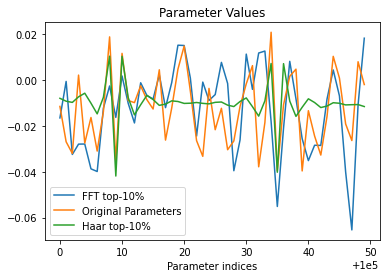

In [150]:
plt.plot(np.arange(100000,100050,1), reverse_top10fft[100000:100050], label = "FFT top-10%")
plt.plot(np.arange(100000,100050,1), conc2[100000:100050], label = "Original Parameters")
plt.plot(np.arange(100000,100050,1), reverse_top10[100000:100050], label = "Haar top-10%")
plt.title('Parameter Values') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter indices")
plt.legend()
plt.draw()
plt.savefig("ParametersWaveletHaar.png")

In [175]:
wavelet = 'haar'
coeff = pywt.wavedec(conc5000.numpy(), wavelet, level = None)
array, coeff_slices = pywt.coeffs_to_array(coeff)
#print(coeff_slices) # should be static so we do not need to send them
topk = torch.topk(
        torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
    )
top10 = torch.zeros(len(array))
top10[topk.indices] = torch.from_numpy(array[topk.indices])
og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
print(wavelet, torch.norm(conc5000 - reverse_top10, 2))

haar tensor(12.0875)


In [176]:
wavelet = 'haar'
coeff = pywt.wavedec(conc5000.numpy(), wavelet, level = None)
array, coeff_slices = pywt.coeffs_to_array(coeff)
#print(coeff_slices) # should be static so we do not need to send them
topk = torch.topk(
        torch.from_numpy(np.absolute(array)), round(0.2*len(array)), dim=0, sorted=False
    )
top10 = torch.zeros(len(array))
top10[topk.indices] = torch.from_numpy(array[topk.indices])
og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
print(wavelet, torch.norm(conc5000 - reverse_top10, 2))

haar tensor(9.4642)


In [177]:
wavelet = 'haar'
coeff = pywt.wavedec(conc5000.numpy(), wavelet, level = 5)
array, coeff_slices = pywt.coeffs_to_array(coeff)
#print(coeff_slices) # should be static so we do not need to send them
print(len(coeff))
topk = torch.topk(
        torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
    )
top10 = torch.zeros(len(array))
top10[topk.indices] = torch.from_numpy(array[topk.indices])
og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
print(wavelet, torch.norm(conc5000 - reverse_top10, 2))

reduced = []
for i, o in enumerate(coeff):
    print(o.shape) 
    if i > 3:
        reduced.append(np.zeros_like(o))
        continue
    reduced.append(o)
reverse_top10 = torch.from_numpy(pywt.waverec(reduced, wavelet = wavelet))
print(wavelet, torch.norm(conc5000 - reverse_top10, 2))

reduced = []
for i, o in enumerate(coeff):
    print(o.shape) 
    if i > 5:
        reduced.append(np.zeros_like(o))
        continue
    reduced.append(o)
reverse_top10 = torch.from_numpy(pywt.waverec(reduced, wavelet = wavelet))
print(wavelet, torch.norm(conc5000 - reverse_top10, 2))
    
    

6
haar tensor(12.1470)
(52814,)
(52814,)
(105628,)
(211256,)
(422512,)
(845023,)
haar tensor(16.9818)
(52814,)
(52814,)
(105628,)
(211256,)
(422512,)
(845023,)
haar tensor(2.3811e-06)


# with resnet

In [178]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /home/jeffrey/.cache/torch/hub/pytorch_vision_v0.10.0


In [179]:
resw = {}
for k,v in model.state_dict().items():
    resw[k] = v.clone()

In [ ]:
flatr = []
for v in resw.values():
    flatr.append(v.flatten())
concr = torch.cat(flatr)

In [190]:
# working on the random initialization
#wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    fft_layers = []
    to_cat = []
    for v in resw.values():
        flat = v.flatten()
        #print(flat.shape)
        lens.append(len(flat))
        to_cat.append(flat)
    flat = torch.cat(to_cat, dim=0)
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = None)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    fft_layers.append(reverse_top10)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

bior1.1 43.02796936035156 115077.1953125
bior1.3 44.042415618896484 117252.8203125
bior1.5 44.798824310302734 119106.71875
bior2.2 44.7282600402832 117956.5
bior2.4 44.04926300048828 116528.5078125
bior2.6 44.09769821166992 116693.171875
bior2.8 44.207454681396484 116984.125
bior3.1 65.93879699707031 171188.890625
bior3.3 52.62727355957031 136826.25
bior3.5 50.10884475708008 130465.40625
bior3.7 49.333717346191406 128473.21875
bior3.9 49.07342529296875 127796.1640625
bior4.4 42.742881774902344 114508.9921875
bior5.5 43.98085403442383 118580.4296875
bior6.8 42.57365417480469 113812.046875
coif1 42.74231719970703 114690.046875
coif2 42.56312561035156 114001.890625
coif3 42.54220199584961 113903.578125
coif4 42.558956146240234 113906.859375
coif5 42.56120681762695 113924.28125
coif6 42.592472076416016 113980.0390625
coif7 42.60406494140625 114030.09375
coif8 42.61618423461914 114052.2734375
coif9 42.6173095703125 114053.078125
coif10 42.63934326171875 114081.7890625
coif11 42.653427124023

In [181]:
len(concr)

11699132

In [197]:
topk_og = torch.topk(
            concr.abs(), round(0.1*len(concr)), dim=0, sorted=False
        )
top10_og = torch.zeros(len(concr))
top10_og[topk_og.indices] = concr[topk_og.indices]

In [198]:
torch.norm(top10_og - concr, 2) 

tensor(47.3773)

In [199]:
to_cat = []
for v in resw.values():
    flat = v.flatten()
    to_cat.append(flat)
flat = torch.cat(to_cat, dim=0)

In [200]:
flat_fft = fft.rfft(flat)
topk = torch.topk(
        flat_fft.abs(), round(0.1*len(flat_fft)), dim=0, sorted=False
    )
top10 = torch.zeros(len(flat_fft), dtype = torch.cfloat)
top10[topk.indices] = flat_fft[topk.indices]
reverse_top10fft = fft.irfft(top10)
fft_layers.append(reverse_top10fft)
err = torch.norm(reverse_top10fft - flat, 2)
print(err)

tensor(71.3879)


In [201]:
coeff = pywt.wavedec(flat.numpy(), "sym2", level = None)
array, coeff_slices = pywt.coeffs_to_array(coeff)
#print(coeff_slices) # should be static so we do not need to send them
topk = torch.topk(
        torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
    )
top10 = torch.zeros(len(array))
top10[topk.indices] = torch.from_numpy(array[topk.indices])
og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
reverse_top10wv = torch.from_numpy(pywt.waverec(og, wavelet = "sym2"))
err = torch.norm(reverse_top10wv - flat, 2)
print(err)

tensor(42.6944)


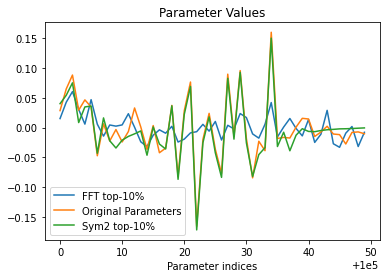

In [202]:
plt.plot(np.arange(100000,100050,1), reverse_top10fft[100000:100050], label = "FFT top-10%")
plt.plot(np.arange(100000,100050,1), concr[100000:100050], label = "Original Parameters")
plt.plot(np.arange(100000,100050,1), reverse_top10wv[100000:100050], label = "Sym2 top-10%")

plt.title('Parameter Values') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter indices")
plt.legend()
plt.draw()
plt.savefig("ParametersWaveletHaar.png")

In [203]:
top10_og[100000:100050]

tensor([ 0.0000,  0.0649,  0.0881,  0.0000,  0.0464,  0.0347, -0.0472,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0365,  0.0000,
        -0.0422, -0.0344,  0.0372, -0.0823,  0.0000,  0.0764, -0.1654,  0.0000,
         0.0000, -0.0363, -0.0769,  0.0896,  0.0000,  0.0955,  0.0000, -0.0843,
         0.0000, -0.0387,  0.1598,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])

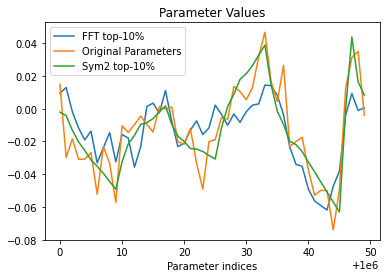

In [204]:
plt.plot(np.arange(1000000,1000050,1), reverse_top10fft[1000000:1000050], label = "FFT top-10%")
plt.plot(np.arange(1000000,1000050,1), concr[1000000:1000050], label = "Original Parameters")
plt.plot(np.arange(1000000,1000050,1), reverse_top10wv[1000000:1000050], label = "Sym2 top-10%")

plt.title('Parameter Values') 
#plt.ylabel("Absolute frequency value")
plt.xlabel("Parameter indices")
plt.legend()
plt.draw()
plt.savefig("ParametersWaveletHaar.png")

## FFT Training<a class="anchor" id="ffttrain"></a>

In [85]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [26]:
stats = {"train": [], "test":[]}
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            flat = g.grad.flatten()
            topk = torch.topk(
            flat.abs(), round(0.1*len(flat)), dim=0, sorted=False
            )
            top10 = torch.zeros(len(flat))
            top10[topk.indices] = flat[topk.indices]
            g.grad = top10.reshape(shape)
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.136391  [    0/735856]
loss: 1.387546  [64000/735856]
loss: 1.009362  [128000/735856]
loss: 0.568759  [192000/735856]
loss: 0.796950  [256000/735856]
loss: 0.670068  [320000/735856]
loss: 0.625332  [384000/735856]
loss: 0.557147  [448000/735856]
loss: 0.701893  [512000/735856]
loss: 0.670033  [576000/735856]
loss: 0.575888  [640000/735856]
loss: 0.654841  [704000/735856]
epoch:
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.578153 

loss: 0.776733  [    0/735856]
loss: 0.519993  [64000/735856]
loss: 0.599282  [128000/735856]
loss: 0.885723  [192000/735856]
loss: 0.514714  [256000/735856]
loss: 0.539040  [320000/735856]
loss: 0.422559  [384000/735856]
loss: 0.382564  [448000/735856]
loss: 0.412677  [512000/735856]
loss: 0.360731  [576000/735856]
loss: 0.534333  [640000/735856]
loss: 0.379236  [704000/735856]
epoch:
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.463718 

loss: 0.367664  [    0/735856]
loss: 0.339760  [64000/735856]
loss: 0.653718  [128000/735856]
loss: 0.410070  [192000/

In [ ]:
# it converges slower than without gradient compression

In [29]:
import torch.fft as fft

In [34]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [35]:
stats = {"train": [], "test":[]}
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            flat = g.grad.flatten()
            
            flat_fft = fft.rfft(flat)
            topk = torch.topk(flat_fft.abs(), round(0.1*len(flat_fft)), dim=0, sorted=False)
            top10 = torch.zeros(len(flat_fft), dtype = torch.cfloat)
            top10[topk.indices] = flat_fft[topk.indices]
            reverse_top10 = fft.irfft(top10)
            g.grad = reverse_top10.reshape(shape)
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.122382  [    0/735856]
loss: 1.659356  [64000/735856]
loss: 1.175072  [128000/735856]
loss: 1.030752  [192000/735856]
loss: 0.891644  [256000/735856]
loss: 0.732518  [320000/735856]
loss: 0.613185  [384000/735856]
loss: 0.483264  [448000/735856]
loss: 0.580724  [512000/735856]
loss: 0.509457  [576000/735856]
loss: 0.661517  [640000/735856]
loss: 0.621521  [704000/735856]
epoch:
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.570322 

loss: 0.543810  [    0/735856]
loss: 0.339085  [64000/735856]
loss: 0.495473  [128000/735856]
loss: 0.384833  [192000/735856]
loss: 0.418521  [256000/735856]
loss: 0.614597  [320000/735856]
loss: 0.515266  [384000/735856]
loss: 0.738823  [448000/735856]
loss: 0.423178  [512000/735856]
loss: 0.473593  [576000/735856]
loss: 0.518021  [640000/735856]
loss: 0.497685  [704000/735856]
epoch:
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.474809 

loss: 0.575689  [    0/735856]
loss: 0.456497  [64000/735856]
loss: 0.429356  [128000/735856]
loss: 0.563055  [192000/

In [36]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [37]:
stats = {"train": [], "test":[]}
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            flat = g.grad.flatten()
            
            flat_fft = fft.rfft(flat)
            topk = torch.topk(flat_fft.abs(), round(0.2*len(flat_fft)), dim=0, sorted=False)
            top10 = torch.zeros(len(flat_fft), dtype = torch.cfloat)
            top10[topk.indices] = flat_fft[topk.indices]
            reverse_top10 = fft.irfft(top10)
            g.grad = reverse_top10.reshape(shape)
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.125680  [    0/735856]
loss: 1.490153  [64000/735856]
loss: 0.797238  [128000/735856]
loss: 0.703639  [192000/735856]
loss: 0.862654  [256000/735856]
loss: 0.674491  [320000/735856]
loss: 0.633835  [384000/735856]
loss: 0.537149  [448000/735856]
loss: 0.579062  [512000/735856]
loss: 0.468447  [576000/735856]
loss: 0.488582  [640000/735856]
loss: 0.529873  [704000/735856]
epoch:
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.489548 

loss: 0.573154  [    0/735856]
loss: 0.466781  [64000/735856]
loss: 0.468422  [128000/735856]
loss: 0.449423  [192000/735856]
loss: 0.357713  [256000/735856]
loss: 0.391187  [320000/735856]
loss: 0.500866  [384000/735856]
loss: 0.368405  [448000/735856]
loss: 0.423239  [512000/735856]
loss: 0.533780  [576000/735856]
loss: 0.623185  [640000/735856]
loss: 0.380635  [704000/735856]
epoch:
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.411804 

loss: 0.485906  [    0/735856]
loss: 0.522850  [64000/735856]
loss: 0.474864  [128000/735856]
loss: 0.453226  [192000/

In [229]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [230]:
# wavelet per layer
stats = {"train": [], "test":[]}
wavelet = 'haar'
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            flat = g.grad.flatten()
            
            coeff = pywt.wavedec(flat.numpy(), wavelet, level = None)
            array, coeff_slices = pywt.coeffs_to_array(coeff)
            #print(coeff_slices) # should be static so we do not need to send them
            topk = torch.topk(
                    torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
                )
            top10 = torch.zeros(len(array))
            top10[topk.indices] = torch.from_numpy(array[topk.indices])
            og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
            reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
            
            g.grad = reverse_top10.reshape(shape)
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.128546  [    0/735856]
loss: 1.380654  [64000/735856]
loss: 1.055664  [128000/735856]
loss: 0.687121  [192000/735856]
loss: 0.728443  [256000/735856]
loss: 0.731651  [320000/735856]
loss: 0.649674  [384000/735856]
loss: 0.474646  [448000/735856]
loss: 0.653415  [512000/735856]
loss: 0.450781  [576000/735856]
loss: 0.629819  [640000/735856]
loss: 0.548388  [704000/735856]
epoch:
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.540368 

loss: 0.767534  [    0/735856]
loss: 0.474996  [64000/735856]
loss: 0.657538  [128000/735856]
loss: 0.388315  [192000/735856]
loss: 0.581206  [256000/735856]
loss: 0.421425  [320000/735856]
loss: 0.494563  [384000/735856]
loss: 0.541493  [448000/735856]
loss: 0.451657  [512000/735856]
loss: 0.382599  [576000/735856]
loss: 0.449485  [640000/735856]
loss: 0.408576  [704000/735856]
epoch:
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.455863 

loss: 0.487152  [    0/735856]
loss: 0.566136  [64000/735856]
loss: 0.388435  [128000/735856]
loss: 0.435407  [192000/

In [31]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
# per layer repeat
stats = {"train": [], "test":[]}
wavelet = 'sym2'
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            flat = g.grad.flatten()
            
            coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
            # print(len(coeff))
            array, coeff_slices = pywt.coeffs_to_array(coeff)
            #print(coeff_slices) # should be static so we do not need to send them
            topk = torch.topk(
                    torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
                )
            top10 = torch.zeros(len(array))
            top10[topk.indices] = torch.from_numpy(array[topk.indices])
            og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
            reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
            
            g.grad = reverse_top10.reshape(shape)
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.114821  [    0/735856]
loss: 1.691283  [64000/735856]
loss: 0.739705  [128000/735856]
loss: 0.878835  [192000/735856]
loss: 0.893373  [256000/735856]
loss: 0.622142  [320000/735856]
loss: 0.729517  [384000/735856]
loss: 0.930510  [448000/735856]
loss: 0.564309  [512000/735856]
loss: 0.820855  [576000/735856]
loss: 0.592394  [640000/735856]
loss: 0.530982  [704000/735856]
epoch:
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.576240 

loss: 0.387244  [    0/735856]
loss: 0.483110  [64000/735856]
loss: 0.544743  [128000/735856]
loss: 0.570393  [192000/735856]
loss: 0.511510  [256000/735856]
loss: 0.335736  [320000/735856]
loss: 0.671059  [384000/735856]
loss: 0.473634  [448000/735856]
loss: 0.559810  [512000/735856]
loss: 0.454633  [576000/735856]
loss: 0.571824  [640000/735856]
loss: 0.626598  [704000/735856]
epoch:
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.482487 

loss: 0.422876  [    0/735856]
loss: 0.769186  [64000/735856]
loss: 0.351542  [128000/735856]
loss: 0.436626  [192000/

In [22]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# wavelet over entire flatten gradient
stats = {"train": [], "test":[]}
wavelet = 'haar'
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        flats = []
        shapes = []
        lens = []
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            shapes.append(shape)
            flat = g.grad.flatten()
            flats.append(flat)
            lens.append(len(flat))
        flat = torch.cat(flats)
        coeff = pywt.wavedec(flat.numpy(), wavelet, level = None)
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        #print(coeff_slices) # should be static so we do not need to send them
        topk = torch.topk(
                torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
            )
        top10 = torch.zeros(len(array))
        top10[topk.indices] = torch.from_numpy(array[topk.indices])
        og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
        reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
            

        
        start_index = 0    
        for i, key in enumerate(model.parameters()):
            end_index = start_index + lens[i]
            key.grad = reverse_top10[start_index:end_index].reshape(shapes[i])
            start_index = end_index
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.135039  [    0/735856]
loss: 1.154176  [64000/735856]
loss: 0.624926  [128000/735856]
loss: 0.605651  [192000/735856]
loss: 0.601686  [256000/735856]
loss: 0.532184  [320000/735856]
loss: 0.627395  [384000/735856]
loss: 0.411491  [448000/735856]
loss: 0.354714  [512000/735856]
loss: 0.393673  [576000/735856]
loss: 0.612208  [640000/735856]
loss: 0.619142  [704000/735856]
epoch:
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.445382 

loss: 0.429652  [    0/735856]
loss: 0.396769  [64000/735856]
loss: 0.423508  [128000/735856]
loss: 0.576669  [192000/735856]
loss: 0.432909  [256000/735856]
loss: 0.515018  [320000/735856]
loss: 0.375972  [384000/735856]
loss: 0.376615  [448000/735856]
loss: 0.326449  [512000/735856]
loss: 0.360019  [576000/735856]
loss: 0.354862  [640000/735856]
loss: 0.522963  [704000/735856]
epoch:
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.383029 

loss: 0.319733  [    0/735856]
loss: 0.486813  [64000/735856]
loss: 0.351780  [128000/735856]
loss: 0.327754  [192000/

In [33]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [34]:
import pywt

In [35]:
# rerun with alpha 0.2
stats = {"train": [], "test":[]}
wavelet = 'sym2'
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        flats = []
        shapes = []
        lens = []
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            shapes.append(shape)
            flat = g.grad.flatten()
            flats.append(flat)
            lens.append(len(flat))
        flat = torch.cat(flats)
        coeff = pywt.wavedec(flat.numpy(), wavelet, level = None)
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        #print(coeff_slices) # should be static so we do not need to send them
        topk = torch.topk(
                torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
            )
        top10 = torch.zeros(len(array))
        top10[topk.indices] = torch.from_numpy(array[topk.indices])
        og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
        reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
            

        
        start_index = 0    
        for i, key in enumerate(model.parameters()):
            end_index = start_index + lens[i]
            key.grad = reverse_top10[start_index:end_index].reshape(shapes[i])
            start_index = end_index
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.126535  [    0/735856]
loss: 1.238513  [64000/735856]
loss: 0.947478  [128000/735856]
loss: 0.758107  [192000/735856]
loss: 0.538468  [256000/735856]
loss: 0.726651  [320000/735856]
loss: 0.523160  [384000/735856]
loss: 0.323133  [448000/735856]
loss: 0.439029  [512000/735856]
loss: 0.406259  [576000/735856]
loss: 0.490085  [640000/735856]
loss: 0.520512  [704000/735856]
epoch:
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.449423 

loss: 0.481995  [    0/735856]
loss: 0.485922  [64000/735856]
loss: 0.363491  [128000/735856]
loss: 0.604679  [192000/735856]
loss: 0.318160  [256000/735856]
loss: 0.321950  [320000/735856]
loss: 0.355750  [384000/735856]
loss: 0.399116  [448000/735856]
loss: 0.283532  [512000/735856]
loss: 0.527641  [576000/735856]
loss: 0.413641  [640000/735856]
loss: 0.309524  [704000/735856]
epoch:
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.406266 

loss: 0.332639  [    0/735856]
loss: 0.438504  [64000/735856]
loss: 0.375174  [128000/735856]
loss: 0.325330  [192000/

In [24]:
v,i = torch.topk(torch.tensor([1,2,3,4]), 2 , dim=0, sorted=False)

In [25]:
v

tensor([4, 3])

In [26]:
i

tensor([3, 2])

In [35]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [36]:
# rerun with alpha 0.2 and level 4
stats = {"train": [], "test":[]}
wavelet = 'coif1'
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
        flats = []
        shapes = []
        lens = []
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            shapes.append(shape)
            flat = g.grad.flatten()
            flats.append(flat)
            lens.append(len(flat))
        flat = torch.cat(flats)
        coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
        # print(len(coeff))
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        #print(coeff_slices) # should be static so we do not need to send them
        topk = torch.topk(
                torch.from_numpy(np.absolute(array)), round(0.2*len(array)), dim=0, sorted=False
            )
        top10 = torch.zeros(len(array))
        top10[topk.indices] = torch.from_numpy(array[topk.indices])
        og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
        reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
            

        
        start_index = 0    
        for i, key in enumerate(model.parameters()):
            end_index = start_index + lens[i]
            key.grad = reverse_top10[start_index:end_index].reshape(shapes[i])
            start_index = end_index
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.126898  [    0/735856]
loss: 1.050626  [64000/735856]
loss: 0.652647  [128000/735856]
loss: 0.648297  [192000/735856]
loss: 0.636182  [256000/735856]
loss: 0.570731  [320000/735856]
loss: 0.509262  [384000/735856]
loss: 0.309913  [448000/735856]
loss: 0.538662  [512000/735856]
loss: 0.530801  [576000/735856]
loss: 0.507737  [640000/735856]
loss: 0.422813  [704000/735856]
epoch:
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.435624 

loss: 0.388328  [    0/735856]
loss: 0.299637  [64000/735856]
loss: 0.420440  [128000/735856]
loss: 0.230143  [192000/735856]
loss: 0.374027  [256000/735856]
loss: 0.279048  [320000/735856]
loss: 0.495672  [384000/735856]
loss: 0.277394  [448000/735856]
loss: 0.395940  [512000/735856]
loss: 0.476103  [576000/735856]
loss: 0.550471  [640000/735856]
loss: 0.431940  [704000/735856]
epoch:
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.391393 

loss: 0.436391  [    0/735856]
loss: 0.351771  [64000/735856]
loss: 0.352133  [128000/735856]
loss: 0.254270  [192000/

In [12]:
lr = 0.0005
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
stats = {"train": [], "test":[]}
for e in range(4):
    #training
    batch = 0
    for X, y in train_dataloader:
        # print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # print("grad2: "+str(model.conv1.bias.grad))
        
        
        # print("params "+ str(len(list(model.parameters()))))
                # print("params "+ str(len(list(model.parameters()))))
        flats = []
        shapes = []
        lens = []
        for g in model.parameters():
            grad = g.grad
            shape = grad.shape
            shapes.append(shape)
            flat = g.grad.flatten()
            flats.append(flat)
            lens.append(len(flat))
        flat = torch.cat(flats)

        topk = torch.topk(
                flat.abs(), round(0.1*len(flat)), dim=0, sorted=False
            )
        top10 = torch.zeros(len(flat))
        top10[topk.indices] = flat[topk.indices]
        
        start_index = 0    
        for i, key in enumerate(model.parameters()):
            end_index = start_index + lens[i]
            key.grad = top10[start_index:end_index].reshape(shapes[i])
            start_index = end_index
            
            
        # print("grad3: "+str(model.conv1.bias.grad))
        
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        # print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.118358  [    0/735856]
loss: 1.330925  [64000/735856]
loss: 0.899926  [128000/735856]
loss: 0.894990  [192000/735856]
loss: 0.475845  [256000/735856]
loss: 0.672299  [320000/735856]
loss: 0.728748  [384000/735856]
loss: 0.374176  [448000/735856]
loss: 0.621309  [512000/735856]
loss: 0.562943  [576000/735856]
loss: 0.567177  [640000/735856]
loss: 0.408742  [704000/735856]
epoch:
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.461047 

loss: 0.545014  [    0/735856]
loss: 0.433877  [64000/735856]
loss: 0.513009  [128000/735856]
loss: 0.462199  [192000/735856]
loss: 0.371584  [256000/735856]
loss: 0.380919  [320000/735856]
loss: 0.448126  [384000/735856]
loss: 0.421078  [448000/735856]
loss: 0.531703  [512000/735856]
loss: 0.314307  [576000/735856]
loss: 0.345081  [640000/735856]
loss: 0.456303  [704000/735856]
epoch:
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.392272 

loss: 0.371980  [    0/735856]
loss: 0.419902  [64000/735856]
loss: 0.344231  [128000/735856]
loss: 0.383977  [192000/

## Node Training <a class="anchor" id="nodetraining"></a>

In [6]:
# From Femnist.py
def read_file(file_path):
    with open(file_path, "r") as inf:
        client_data = json.load(inf)
        print("loaded the data")
    return (
        client_data["users"],
        client_data["num_samples"],
        client_data["user_data"],
    )

In [7]:
735856 / 96


7665.166666666667

In [8]:
with open(train_dir+"femnist.pkl", "rb") as f:
    train = pickle.load(f)

In [9]:
with open(train_dir+"femnist_test.pkl", "rb") as f:
    test = pickle.load(f)

In [10]:
train["train_x"].shape

(735856, 1, 28, 28)

In [11]:
NUM_CLASSES = 62
IMAGE_SIZE = (28, 28)
FLAT_SIZE = 28 * 28
PIXEL_RANGE = 256.0
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Class for a CNN Model for FEMNIST

    """

    def __init__(self):
        """
        Constructor. Instantiates the CNN Model
            with 28*28*1 Input and 62 output classes

        """
        super().__init__()
        # 1.6 million params
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        """
        Forward pass of the model

        Parameters
        ----------
        x : torch.tensor
            The input torch tensor

        Returns
        -------
        torch.tensor
            The output torch tensor

        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
train["train_y"].shape

(735856,)

In [13]:
import os
from torch.utils.data import Dataset

class FemnistDataset(Dataset):
    def __init__(self, training, transform=None, target_transform=None):
        if training:
            with open(train_dir+"femnist.pkl", "rb") as f:
                train = pickle.load(f)
                self.data = train["train_x"][10000:10000+7665,...]
                self.label = train["train_y"][10000:10000+7665,...]
        else: 
            with open(train_dir+"femnist_test.pkl", "rb") as f:
                test = pickle.load(f)
                self.data = test["test_x"]
                self.label = test["test_y"]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [14]:
from torch.utils.data import DataLoader

In [15]:
trainset = FemnistDataset(True)
testset = FemnistDataset(False)

train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=True)

In [16]:
len(train_dataloader)

480

In [17]:
lr = 0.001
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
list(model.state_dict().values())[1]

tensor([-0.1487, -0.1003,  0.0990, -0.0245, -0.1023,  0.0974, -0.1139, -0.1425,
        -0.1949, -0.0679, -0.0937,  0.0891,  0.0577, -0.1357,  0.0814,  0.1157,
        -0.1997, -0.1665, -0.1546,  0.1150,  0.0895, -0.1049, -0.0980, -0.0980,
         0.0729,  0.1947,  0.0421, -0.0365, -0.1470, -0.1679,  0.0286, -0.0146])

In [19]:
list(model.state_dict().values())[1]

tensor([-0.1487, -0.1003,  0.0990, -0.0245, -0.1023,  0.0974, -0.1139, -0.1425,
        -0.1949, -0.0679, -0.0937,  0.0891,  0.0577, -0.1357,  0.0814,  0.1157,
        -0.1997, -0.1665, -0.1546,  0.1150,  0.0895, -0.1049, -0.0980, -0.0980,
         0.0729,  0.1947,  0.0421, -0.0365, -0.1470, -0.1679,  0.0286, -0.0146])

In [ ]:
stats = {"train": [], "test":[]}
for e in range(20):
    #training
    batch = 0
    for X, y in train_dataloader:
        #print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        #print("grad2: "+str(model.conv1.bias.grad))
        optimizer.step()
        model.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        #print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.158939  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 34.5%, Avg loss: 2.492351 

loss: 2.274407  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 49.2%, Avg loss: 2.004063 

loss: 2.080229  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 57.7%, Avg loss: 1.550052 

loss: 1.220055  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 62.5%, Avg loss: 1.387109 

loss: 0.547404  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 62.6%, Avg loss: 1.411219 

loss: 0.666172  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 68.1%, Avg loss: 1.147880 

loss: 0.539106  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 66.9%, Avg loss: 1.218418 

loss: 1.057546  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 68.9%, Avg loss: 1.211012 

loss: 0.315841  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 66.5%, Avg loss: 1.400047 

loss: 0.659244  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.484381 

loss: 0.437452  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 69.8%, Avg loss: 1.239514 

loss: 0.675393  [    

In [17]:
lr = 0.001
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

In [18]:
stats = {"train": [], "test":[]}
for e in range(20):
    #training
    batch = 0
    for X, y in train_dataloader:
        #print("grad: "+str(model.conv1.bias.grad))
        old = model.conv1.bias.clone()
        X = X.to(device)
        y = y.to(device)
        #print(len(label))
        size = len(train_dataloader.dataset)
        model.train()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
        #to_cat = []
        #for v in model.state_dict.values():
         #   flat = v.flatten()
          #  to_cat.append(flat)
        #flat = torch.cat(to_cat, dim=0)
        #loss = loss_fn(pred,y) + 0.02*torch.norm(flat, 2)
        # Backpropagation
        loss.backward()
        #print("grad2: "+str(model.conv1.bias.grad))
        optimizer.step()
        optimizer.zero_grad()
        #optimizer.zero_grad()
        
        #resetting the optimizer
        # optimizer.load_state_dict(model.state_dict())
        vals = optimizer.state.values()
        #print(optimizer.state.values())

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            stats["train"].append([batch, e*size + current, loss])
        batch += 1
    
    #testing
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("epoch:")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    stats["test"].append([e, test_loss, 100*correct])

loss: 4.158939  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 26.3%, Avg loss: 2.828093 

loss: 2.478634  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 47.1%, Avg loss: 2.069258 

loss: 2.099130  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.571264 

loss: 1.343866  [    0/ 7665]
epoch:
Test Error: 
 Accuracy: 61.1%, Avg loss: 1.432287 

loss: 0.783433  [    0/ 7665]


KeyboardInterrupt: 

In [ ]:
after 8: Accuracy: 67.3%, Avg loss: 1.200284 